# 1. Setup
We start off by importing the Python libraries we need. We also import the `essays` dataset (`essays.csv`) that we can find in the `data` directory of our project.

In [101]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

essays_raw = pd.read_csv('data/essays.csv', engine='python');
essays_raw.columns = essays_raw.columns.str.replace("c|#", "").str.lower()

# 2. Inpect the data

Let's take a quick look at the structure of the `essays` dataset.

In [4]:
# Print the first few rows of the dataset
print(essays_raw.head())

# Print the number of rows and colums
print("\nNumber of rows and columns: {} \n".format(essays_raw.shape))

# Check if author ids are unique
if len(essays_raw['authid']) == len(essays_raw):
    print('All author ids are unique!')
else:
    print('Author ids are not unique!')
    
# Check if there are missing values in the dataset:
essays_raw.isnull().sum()

            authid                                               text ext neu  \
0  1997_504851.txt  Well, right now I just woke up from a mid-day ...   n   y   
1  1997_605191.txt  Well, here we go with the stream of consciousn...   n   n   
2  1997_687252.txt  An open keyboard and buttons to push. The thin...   n   y   
3  1997_568848.txt  I can't believe it!  It's really happening!  M...   y   n   
4  1997_688160.txt  Well, here I go with the good old stream of co...   y   n   

  agr con opn  
0   y   n   y  
1   y   n   n  
2   n   y   y  
3   y   y   n  
4   y   n   y  

Number of rows and columns: (2467, 7) 

All author ids are unique!


authid    0
text      0
ext       0
neu       0
agr       0
con       0
opn       0
dtype: int64

We can see that we have a datasset containing 2467 essays from the same number of individual authors. We can also see that the dataset does not contain any missing values. Each essay is associated with an author id and 5 binary labels (one label per personality dimension):

* Extraversion (`ext`)
* Neuroticism (`neu`)
* Agreeableness (`agr`)
* Conscientiousness (`con`)
* Openess (`opn`)

Note that in psychological theory, the Big Five model actually considers all five traits as independent continious dimensions (and even defines sub dimensions - so-called facets - for each of them). However, for this machine learning task, the labels in our datasets represent just binary categories (e.g. a value of `y` in the `neu`-column indicates that the author of the given essay is neurotic).

Obviously, our goal is to predict the five binary labels for a given essay. In the other words, the task at hand is a binary multi label classification task. Before we create a train-test split and preprocess our data, let's explore it a little bit further. For example we can look at the distribution of labels for each dimension.

In [25]:
label_counts = pd.melt(essays_raw.iloc[:, 2:7].apply(pd.Series.value_counts).reset_index().copy(),
                       id_vars = ['index'], var_name = 'dimension', value_name = 'count').rename(columns = {'index': 'label'})

label_counts

,label,dimension,count
0,n,ext,1191
1,y,ext,1276
2,n,neu,1234
3,y,neu,1233
4,n,agr,1157
5,y,agr,1310
6,n,con,1214
7,y,con,1253
8,n,opn,1196
9,y,opn,1271


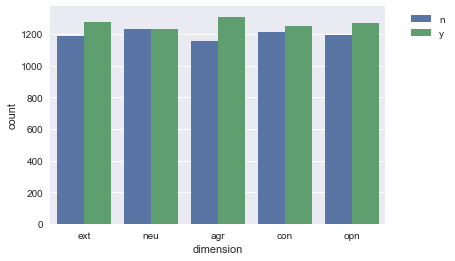

In [59]:
sns.barplot(x = "dimension", y = "count", hue = "label", data = label_counts)
plt.legend(loc = 'center right')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)

In the plot we can see that for each dimension the number of samples on the positive class (`y`) is roughly equal to the number of samples of the negative class (`n`). In other words, our dataset is appears to be pretty balanced (at least, if you look at each dimension separatly) Let's also look at the counts of individual combinations of dimensions:

32

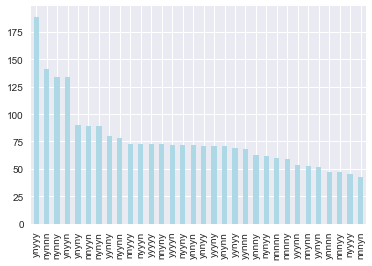

In [79]:
indiv_combs = (essays_raw['ext'] + essays_raw['neu'] + essays_raw['agr'] + essays_raw['con'] + essays_raw['opn']). \
               value_counts()

indiv_combs.plot(kind = "bar", color = "lightblue")
len(indiv_combs)

From the plot above we can see that the individual combinations of dimensions are not equally frequent. Depending on how we attempt to solve our classification problem later on, this is something we want to keep in mind.

As another exploration step, let's take a look at the number of characters in the `text`-column:

AxesSubplot(0.125,0.125;0.775x0.755)


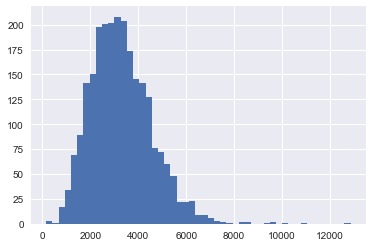

In [89]:
char_counts = essays_raw.text.str.len()

print(char_counts.hist(bins = int(np.sqrt(len(essays_raw)))))

Most essays appear to be between 2000 and 4000 characters long. There appear to some outliers as well (e.g. at least one essay with more than 12000 characters). This is something we want to keep in mind for later, as well.

Also, we should look at some sample essays to see which kind of preprocessing we should to later on:

In [97]:
essays_raw.text[0].replace('\\', '')

'Well, right now I just woke up from a mid-day nap. It\'s sort of weird, but ever since I moved to Texas, I have had problems concentrating on things. I remember starting my homework in  10th grade as soon as the clock struck 4 and not stopping until it was done. Of course it was easier, but I still did it. But when I moved here, the homework got a little more challenging and there was a lot more busy work, and so I decided not to spend hours doing it, and just getting by. But the thing was that I always paid attention in class and just plain out knew the stuff, and now that I look back, if I had really worked hard and stayed on track the last two years without getting  lazy, I would have been a genius, but hey, that\'s all good. It\'s too late to correct the past, but I don\'t really know how to stay focused n the future. The one thing I know is that when  people say that b/c they live on campus they can\'t concentrate, it\'s b. s. For me it would be easier there, but alas, I\'m livin

The text looks pretty messy: For example, there are a lot of special characters and abbreviations. This is not optimal if if you want to feed the text to a model.

# 3. Preprocessing

In this part, we will create a nice and clean dataset that we can feed into a machine learning model.
First, we drop the `authid` column because we actually do not need it for the classification task.

In [106]:
essays = essays_raw.drop(["authid"], axis = 1); essays

,text,ext,neu,agr,con,opn
0,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,I can't believe it! It's really happening! M...,y,n,y,y,n
4,"Well, here I go with the good old stream of co...",y,n,y,n,y
5,Today. Had to turn the music down. Today I wen...,y,n,y,n,y
6,Stream of consciousness. What should I write a...,n,n,y,n,n
7,The RTF305 Usenet site is a piece of garbage! ...,n,n,n,y,y
8,I'm really unsure about this assignment becaus...,y,y,n,y,y
9,Today was a tough day for me. I can't believed...,y,y,y,y,n


Next, we use a function to clean the `text` column:

In [102]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

clean_text(essays_raw.text[0])

'well right now i just woke up from a mid day nap it sort of weird but ever since i moved to texas i have had problems concentrating on things i remember starting my homework in 10th grade as soon as the clock struck 4 and not stopping until it was done of course it was easier but i still did it but when i moved here the homework got a little more challenging and there was a lot more busy work and so i decided not to spend hours doing it and just getting by but the thing was that i always paid attention in class and just plain out knew the stuff and now that i look back if i had really worked hard and stayed on track the last two years without getting lazy i would have been a genius but hey that all good it too late to correct the past but i do not really know how to stay focused n the future the one thing i know is that when people say that b c they live on campus they can not concentrate it b s for me it would be easier there but alas i am living at home under the watchful eye of my 

We also convert the `y` labels to 1s on the `n` labels to 0s for each personality dimension.

In [109]:
# np.where(essays.ext == "y", 1, 0)